# Group Project Baseline Model: Predicting IMDb Movie Ratings


In [ ]:
# Upload TMDB 5000 dataset files to Colab
from google.colab import files
print('Please upload both CSV files: tmdb_5000_movies.csv and tmdb_5000_credits.csv')

uploaded = files.upload()

Please upload both CSV files: tmdb_5000_movies.csv and tmdb_5000_credits.csv


Saving tmdb_5000_credits.csv to tmdb_5000_credits.csv
Saving tmdb_5000_movies.csv to tmdb_5000_movies.csv


In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report,
    r2_score, mean_absolute_error, mean_squared_error
)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

credits = credits.rename(columns={'movie_id': 'id'})
tmdb = movies.merge(credits[['id', 'cast', 'crew']], on='id', how='left')

print('TMDB dataset successfully loaded.')
print('Rows:', tmdb.shape[0], '| Columns:', tmdb.shape[1])
tmdb.head()


TMDB dataset successfully loaded.
Rows: 4803 | Columns: 22


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


#Part B: Data Preparation and Feature Extraction
##Preprocessing TMDB Data

In [ ]:
from ast import literal_eval
import pandas as pd

def parse_list(s):
    try:
        lst = literal_eval(s) if isinstance(s, str) else []
        return lst if isinstance(lst, list) else []
    except Exception:
        return []

def top_genre(lst):
    names = [d.get('name') for d in lst if isinstance(d, dict) and 'name' in d]
    return names[0] if names else None

def get_director(lst):
    for d in lst:
        if d.get('job') == 'Director':
            return d.get('name')
    return None

# Extract first element of list (for keywords, companies)
def first_name(x):
    if isinstance(x, list) and len(x) > 0:
        # some lists contain dicts, some contain strings
        if isinstance(x[0], dict) and 'name' in x[0]:
            return x[0]['name']
        return x[0]
    return None


# Parse list-type columns

for col in ['genres', 'cast', 'crew']:
    if col in tmdb.columns:
        tmdb[col] = tmdb[col].apply(parse_list)

for col in ['keywords', 'production_companies']:
    if col in tmdb.columns:
        tmdb[col] = tmdb[col].apply(parse_list)


# Interpretable features

tmdb['top_genre']      = tmdb['genres'].apply(top_genre)
tmdb['director']       = tmdb['crew'].apply(get_director)
tmdb['top_keyword']    = tmdb['keywords'].apply(first_name)
tmdb['top_company']    = tmdb['production_companies'].apply(first_name)

tmdb['num_keywords']   = tmdb['keywords'].apply(len)
tmdb['num_companies']  = tmdb['production_companies'].apply(len)
tmdb['num_cast']       = tmdb['cast'].apply(len)


# Has collection (binary)

if 'belongs_to_collection' in tmdb.columns:
    tmdb['has_collection'] = tmdb['belongs_to_collection'].notna().astype(int)
else:
    tmdb['has_collection'] = 0


# Company popularity

company_counts = tmdb['top_company'].value_counts()
tmdb['company_popularity'] = tmdb['top_company'].map(company_counts).fillna(0)

# Numeric feature cleaning

base_cols_num = ['runtime', 'budget', 'revenue', 'vote_count', 'popularity']

for c in base_cols_num:
    if c in tmdb.columns:
        tmdb[c] = tmdb[c].fillna(tmdb[c].median())


# Release year

tmdb['release_year'] = pd.to_datetime(tmdb['release_date'], errors='coerce').dt.year
tmdb['release_year'] = tmdb['release_year'].fillna(tmdb['release_year'].median())

# Target variable

tmdb['y_reg'] = tmdb['vote_average']


# Final feature table (full model)

use_cols = base_cols_num + [
    'release_year',
    'top_genre', 'director',
    'top_keyword', 'top_company',
    'num_keywords', 'num_companies', 'num_cast',
    'has_collection', 'company_popularity',
    'y_reg'
]

data = tmdb[use_cols].dropna(subset=['y_reg']).copy()

print('Prepared feature table:', data.shape)
data.head()

# Baseline model version (smaller)

baseline_cols = base_cols_num + [
    'release_year',
    'top_genre', 'director',
    'y_reg'
]

data_baseline = tmdb[baseline_cols].dropna(subset=['y_reg']).copy()

print('Prepared baseline feature table:', data_baseline.shape)
data_baseline.head()

Prepared feature table: (4803, 16)
Prepared baseline feature table: (4803, 9)


,runtime,budget,revenue,vote_count,popularity,release_year,top_genre,director,y_reg
0,162.0,237000000,2787965087,11800,150.437577,2009.0,None,None,7.2
1,169.0,300000000,961000000,4500,139.082615,2007.0,None,None,6.9
2,148.0,245000000,880674609,4466,107.376788,2015.0,None,None,6.3
3,165.0,250000000,1084939099,9106,112.312950,2012.0,None,None,7.6
4,132.0,260000000,284139100,2124,43.926995,2012.0,None,None,6.1


In [ ]:
from collections import Counter

#Extractions for company names
tmdb['company_names'] = tmdb['production_companies'].apply(
    lambda list: [d('name') for d in list if isinstance(d, list) and
  'name' in d])
#Extraction of keyword names
tmdb['keyword_names'] = tmdb['keywords'].apply(
    lambda list: [d('name') for d in list if isinstance(d, dict) and 'name' in dic])
#Extraction of actor names
tmdb['actor_names'] = tmdb['cast'].apply(
    lambda list: [d('name') for d in list if isinstance(d, dict) and 'name' in d])


#Part C: Create Classification Target and Data-Driven Threshold
## Defining High vs. Low Rating Threshold


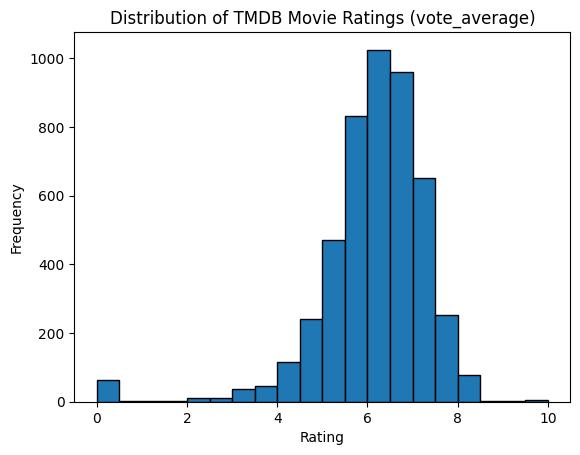

Median threshold: 6.2
KMeans cluster-based threshold: 5.81

High-rated (1): 2555
Low-rated  (0): 2248

Example of labeled data:


,y_reg,y_clf
0,7.2,1
1,6.9,1
2,6.3,1
3,7.6,1
4,6.1,0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

#Plot distribution of movie ratings
plt.hist(data['y_reg'], bins=20, edgecolor='black')
plt.title('Distribution of TMDB Movie Ratings (vote_average)')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#Data-driven threshold(median and K-Means)
median_threshold = data['y_reg'].median()
km = KMeans(n_clusters=2, random_state=42)
data_nonull = data[['y_reg']].dropna()
clusters = km.fit_predict(data_nonull)
centers = sorted(km.cluster_centers_.flatten())
cluster_threshold = np.mean(centers)

print('Median threshold:', round(median_threshold, 2))
print('KMeans cluster-based threshold:', round(cluster_threshold, 2))

#Choose threshold (we’ll use median for baseline)
threshold = median_threshold
data['y_clf'] = (data['y_reg'] >= threshold).astype(int)

#Show counts for balance check
print('\nHigh-rated (1):', data['y_clf'].sum())
print('Low-rated  (0):', len(data) - data['y_clf'].sum())
print('\nExample of labeled data:')
data[['y_reg', 'y_clf']].head()

#Part D: Encode Features, Split Data, and Scale

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# -------------------------------
# Define categorical and numeric columns
# -------------------------------

cat_cols = ['top_genre', 'director', 'top_keyword', 'top_company']

num_cols = [
    'runtime', 'budget', 'revenue', 'vote_count', 'popularity', 'release_year',
    'num_keywords', 'num_companies', 'num_cast',
    'has_collection', 'company_popularity'
]

# Feature matrix
X_base = data[cat_cols + num_cols].copy()

# One-hot encode categorical columns

X_encoded = pd.get_dummies(X_base, columns=cat_cols, dummy_na=True)

# Targets

y_clf = data['y_clf']   # classification target (must already exist)
y_reg = data['y_reg']   # regression target

# Train/test splits

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_encoded, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_encoded, y_reg, test_size=0.2, random_state=42
)

# Scale numeric columns

scaler_c = StandardScaler()
scaler_r = StandardScaler()

# Only scale numeric columns that actually exist post-encoding
num_cols_present = [c for c in num_cols if c in X_encoded.columns]

# Classification scaling
X_train_c[num_cols_present] = scaler_c.fit_transform(X_train_c[num_cols_present])
X_test_c[num_cols_present]  = scaler_c.transform(X_test_c[num_cols_present])

# Regression scaling
X_train_r[num_cols_present] = scaler_r.fit_transform(X_train_r[num_cols_present])
X_test_r[num_cols_present]  = scaler_r.transform(X_test_r[num_cols_present])

# Sanity checks

print('Classification shapes -> X_train:', X_train_c.shape, '| X_test:', X_test_c.shape)
print('Regression shapes -> X_train:', X_train_r.shape, '| X_test:', X_test_r.shape)

print('\nClass balance (train):')
print('High-rated (1):', int(y_train_c.sum()),
      '| Low-rated (0):', int((y_train_c == 0).sum()))

print('\nFeature count after encoding:', X_encoded.shape[1])

Classification shapes -> X_train: (3842, 15) | X_test: (961, 15)
Regression shapes -> X_train: (3842, 15) | X_test: (961, 15)

Class balance (train):
High-rated (1): 2044 | Low-rated (0): 1798

Feature count after encoding: 15


#Part E: Baseline Classification Model (Logistic Regression)

=== Logistic Regression – Classification Results ===
Accuracy : 0.7211
F1 Score : 0.7271
ROC-AUC  : 0.7824

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.75      0.71       450
           1       0.76      0.70      0.73       511

    accuracy                           0.72       961
   macro avg       0.72      0.72      0.72       961
weighted avg       0.72      0.72      0.72       961

Confusion Matrix:
 [[336 114]
 [154 357]]


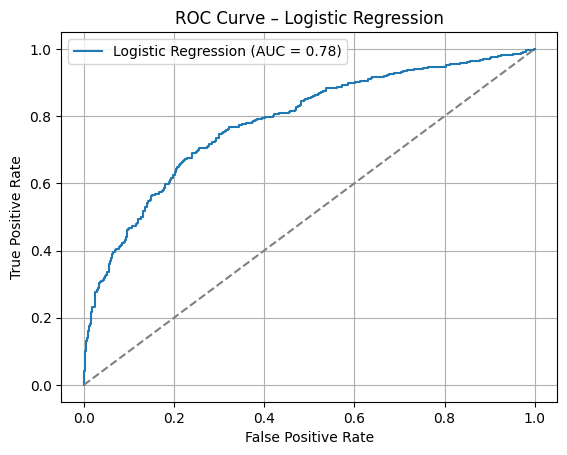

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt

#Train baseline Logistic Regression model
logit = LogisticRegression(max_iter=200, random_state=42)
logit.fit(X_train_c, y_train_c)

#Predictions and probabilities
y_pred_c = logit.predict(X_test_c)
y_prob_c = logit.predict_proba(X_test_c)[:, 1]

#Evaluation metrics
acc = accuracy_score(y_test_c, y_pred_c)
f1 = f1_score(y_test_c, y_pred_c)
roc_auc = roc_auc_score(y_test_c, y_prob_c)

print('=== Logistic Regression – Classification Results ===')
print('Accuracy :', round(acc, 4))
print('F1 Score :', round(f1, 4))
print('ROC-AUC  :', round(roc_auc, 4))
print('\nClassification Report:\n', classification_report(y_test_c, y_pred_c))

#Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_c)
print('Confusion Matrix:\n', cm)

#ROC Curve
fpr, tpr, _ = roc_curve(y_test_c, y_prob_c)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve – Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


#Part F: Baseline Regression Model (Linear Regression)

Ridge Regression with Polynomial Features
RMSE: 1.0283
MAE : 0.6613
R2  : 0.2987


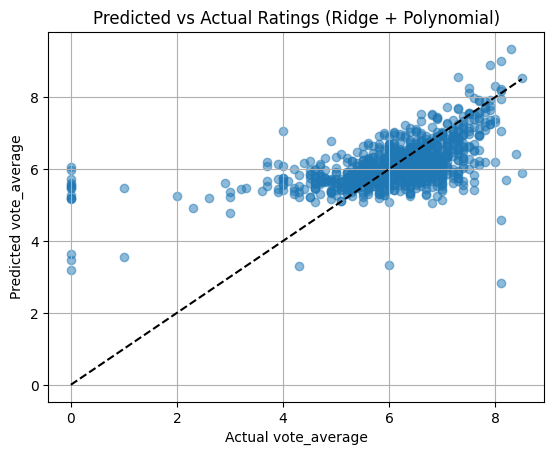

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Polynomial feature expansion

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_r_poly = poly.fit_transform(X_train_r)
X_test_r_poly  = poly.transform(X_test_r)

# Ridge Regression model

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_r_poly, y_train_r)

# Predictions

y_pred_r = ridge.predict(X_test_r_poly)

# Evaluation metrics

mse  = mean_squared_error(y_test_r, y_pred_r)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_r, y_pred_r)
r2   = r2_score(y_test_r, y_pred_r)

print('Ridge Regression with Polynomial Features')
print('RMSE:', round(rmse, 4))
print('MAE :', round(mae, 4))
print('R2  :', round(r2, 4))

# Predicted vs Actual Plot

plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot(
    [y_test_r.min(), y_test_r.max()],
    [y_test_r.min(), y_test_r.max()],
    'k--'
)
plt.title('Predicted vs Actual Ratings (Ridge + Polynomial)')
plt.xlabel('Actual vote_average')
plt.ylabel('Predicted vote_average')
plt.grid(True)
plt.show()
plt.show()

Findings and Business Implications:


By using the TMDb 5000 dataset, we successfully combined structured variables such as budget, revenue, and vote count with engineered categorical features such as top genre, cast, and director. These features reflect both financial investments and creative factors the allow the model to capture multiple factors of movie ratings rather than relying solely on popularity.

The Logisitic Regression classifer was used to predict if a movie could be organized by high rated or low rated based on a threshold of IMDb ratings. However, the Ridge Regression model used the polymonial features that were used to predict continous IMDb ratings. Ridge regularization helped control overfitting. The predicted values versus the actual results indicate that the model captures the trend in rating but there is room for improvement to accurately predict extreme outcomes such as extreme high and low ratings.

The business implications consist with the model being used as an early screening tool to flag projects that could receive above average ratings. The features imply that the certain factors such as budget, cast popularity, and release timing can have a strong association with the ratings; however, these features are not determinative. This also impacts the markerting aspect of the movie, such as building brand strength and narratives that are tied to recognizable directors or cast.

In conclusion, there is room for improvements to work with more expressive models and have enhanced text based features from keywords and companies' metadata.  